# Data preparation

In [ ]:
!pip install scikit-learn -U
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Brain-Computer Interfaces/SSVEP Dataset/'
mat = loadmat(DATASET_PATH + 'SSVEP_Data.mat')
electrodes = ['Oz', 'O1', 'O2', 'POz', 'PO3', 'PO4', 'PO7', 'PO8']
sr = 256

In [ ]:
mat['data1'].shape

(1280, 8, 160)

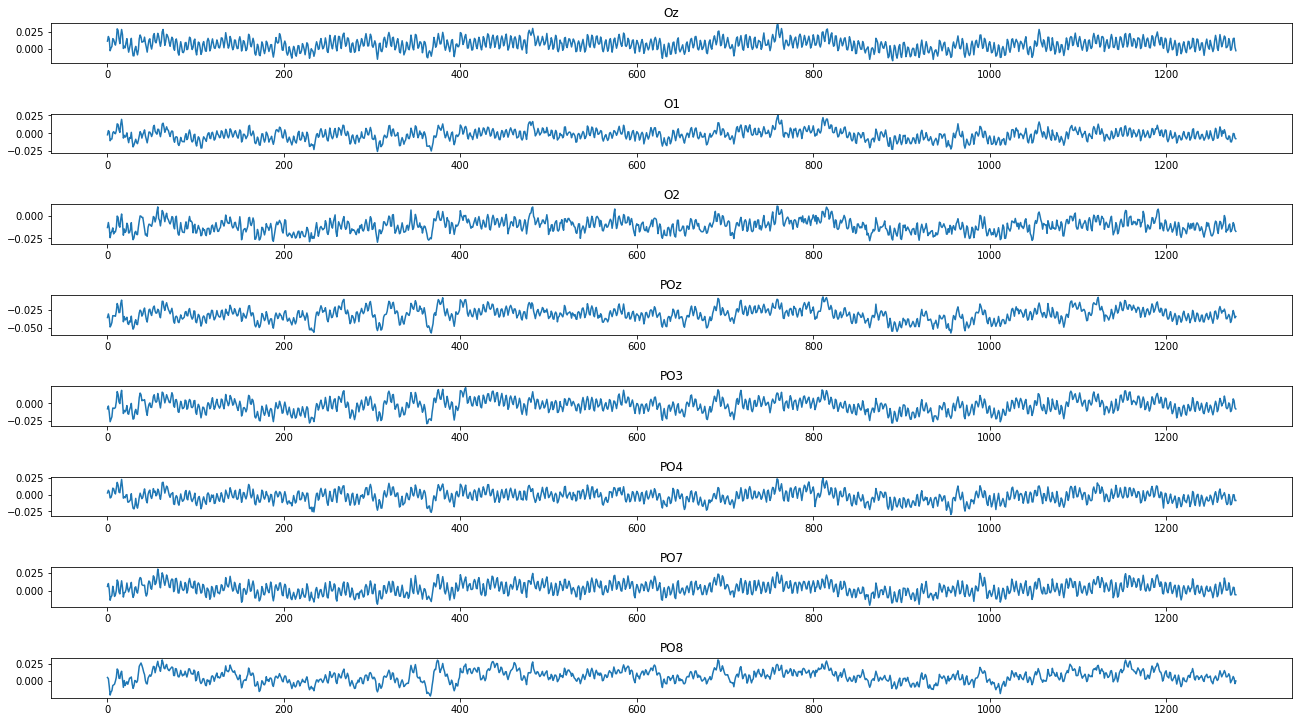

In [ ]:
fig, axs = plt.subplots(8)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout(pad=3.0)

sample = mat['data1'][:, :, 11]

for i in range(8):
    axs[i].plot(sample[:, i])
    axs[i].set_title(electrodes[i])

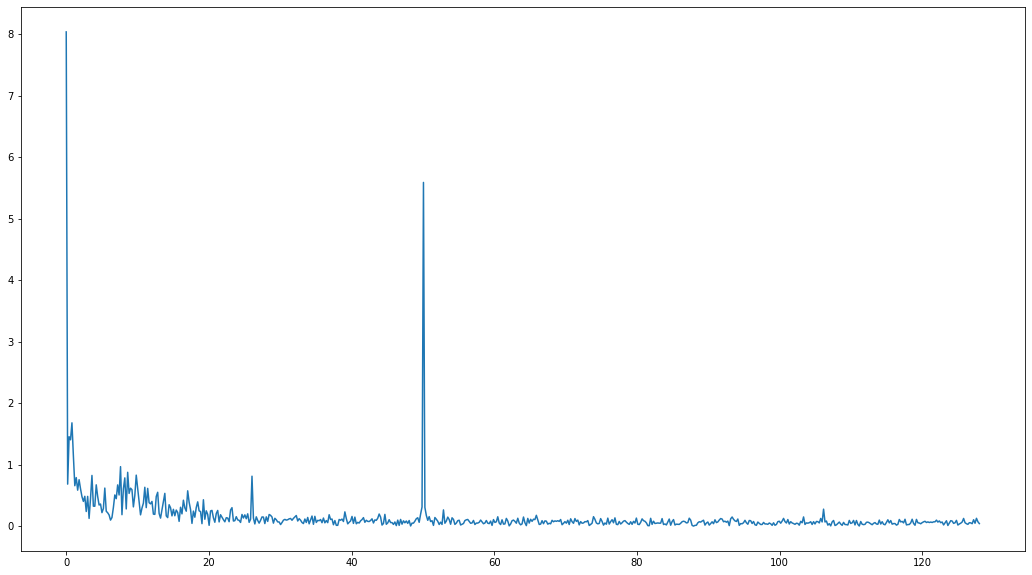

In [ ]:
def butter_bandstop_filter(data, lowcut, highcut, fs, order):
    data_out = []
    for i in range(data.shape[1]):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = signal.butter(order, [low, high], btype='bandstop')
        y = signal.filtfilt(b, a, data[:, i])
        data_out.append(y)
    return np.array(data_out).T

def car_filter(the_cnt):
    ref = np.mean(the_cnt, axis=1)
    cnt_localized = the_cnt - np.mean(the_cnt, axis=1).reshape((the_cnt.shape[0], 1))
    return cnt_localized

def frequency_domain(sig):
    n = len(sig)
    rf = np.linspace(0, sr / 2, num=round(n/2))
    fx = np.fft.fft(sig)
    fx = fx[:round(len(sig)/2)]           
    fx = np.absolute(fx)
    return fx

def plot_magnitude_spectrum(sig):
    n = len(sig)
    rf = np.linspace(0, sr / 2, num=round(n/2))
    fx = np.fft.fft(sig)
    fx = fx[:round(len(sig)/2)]           
    fx = np.absolute(fx)
    plt.figure(figsize=(18, 10))
    plt.plot(rf, fx)

    # f_stim_1 = 13
    # band_1 = [1 if each > f_stim_1 - 1 and each < f_stim_1 + 1 else 0 for each in rf]
    # plt.plot(rf, band_1)
    
    # plt.xlabel('Frequency (Hz)')
    plt.show()

def butter_lowpass_filter(sig, fh, sr, order):
    n = len(sig)
    rf = np.linspace(0, sr / 2, num=round(n/2))
    rf = list(rf) + list(reversed(rf))
    H = [1 if x < fh else 0 for x in rf]
    H = np.array(H + [0, 0, 0])
    fx = np.fft.fft(sig, n)
    Fx = fx * H[:len(fx)]
    new_sig = np.real(np.fft.ifft(Fx))
    return new_sig

def butter_highpass_filter(sig, fh, sr, order):
    n = len(sig)
    rf = np.linspace(0, sr / 2, num=round(n/2))
    rf = list(rf) + list(reversed(rf))
    H = [1 if x > fh else 0 for x in rf]
    H = np.array(H + [1, 1, 1])
    fx = np.fft.fft(sig, n)
    Fx = fx * H[:len(fx)]
    new_sig = np.real(np.fft.ifft(Fx))
    return new_sig

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    y = signal.filtfilt(b, a, data, axis=0)
    return y

plot_magnitude_spectrum(sample[:, 0])

In [ ]:
sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
sample_localized = car_filter(sample_denoised)
sample_localized.shape

(1280, 8)

Text(0.5, 1.0, 'Sample Localized')

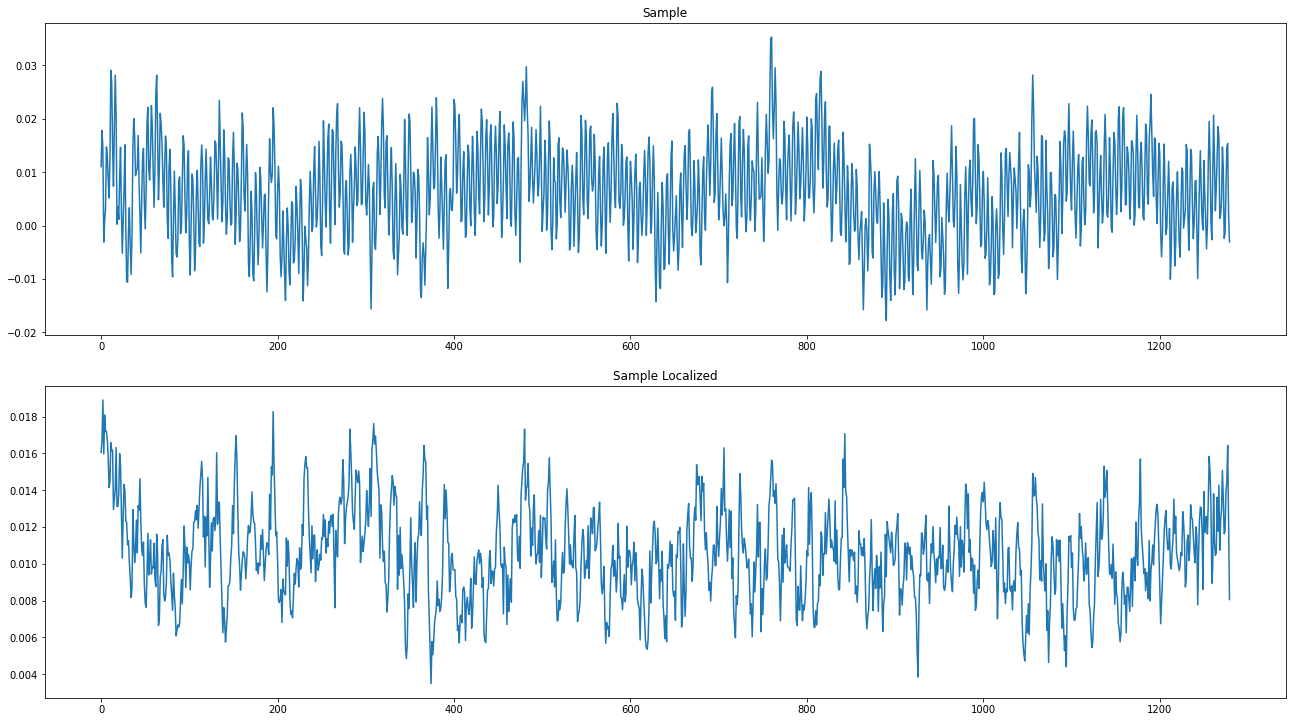

In [ ]:
fig, axs = plt.subplots(2)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout(pad=3.0)

axs[0].plot(sample[:, 0])
axs[0].set_title('Sample')

axs[1].plot(sample_localized[:, 0])
axs[1].set_title('Sample Localized')

In [ ]:
x = sample_localized[:, 0]
p = frequency_domain(x) ** 2
x.shape, p.shape

((1280,), (640,))

In [ ]:
n = len(x)
rf = np.linspace(0, sr / 2, num=round(n/2))
for i in range(len(rf)):
    print(i, rf[i])

0 0.0
1 0.20031298904538342
2 0.40062597809076683
3 0.6009389671361502
4 0.8012519561815337
5 1.001564945226917
6 1.2018779342723005
7 1.402190923317684
8 1.6025039123630673
9 1.8028169014084507
10 2.003129890453834
11 2.2034428794992174
12 2.403755868544601
13 2.6040688575899846
14 2.804381846635368
15 3.004694835680751
16 3.2050078247261347
17 3.4053208137715183
18 3.6056338028169015
19 3.8059467918622847
20 4.006259780907668
21 4.206572769953052
22 4.406885758998435
23 4.607198748043818
24 4.807511737089202
25 5.007824726134586
26 5.208137715179969
27 5.408450704225352
28 5.608763693270736
29 5.809076682316119
30 6.009389671361502
31 6.209702660406886
32 6.410015649452269
33 6.610328638497653
34 6.810641627543037
35 7.010954616588419
36 7.211267605633803
37 7.411580594679187
38 7.611893583724569
39 7.812206572769953
40 8.012519561815337
41 8.21283255086072
42 8.413145539906104
43 8.613458528951487
44 8.81377151799687
45 9.014084507042254
46 9.214397496087637
47 9.414710485133021
48 

In [ ]:
idx_13 = 65
p[idx_13 - 1], p[idx_13], p[idx_13 + 1]

(0.0009062108330981655, 0.31850414954719586, 0.003221989008232285)

In [ ]:
f_stim_1 = 13
f_stim_1_candidates = np.argwhere((rf >= f_stim_1 - 0.2) & (rf <= f_stim_1 + 0.2))
tmp_max = np.argmax(p[f_stim_1_candidates])
f_stim_1_idx = f_stim_1_candidates[tmp_max][0]
p_stim_1 = p[f_stim_1_idx]

print(f_stim_1_candidates)
print()
print(p[f_stim_1_candidates])
print()
print(f_stim_1_idx)
print()
print(p_stim_1)

[[64]
 [65]]

[[0.00090621]
 [0.31850415]]

65

0.31850414954719586


In [ ]:
fres = sr / x.shape[0]
n = 6
step = fres * (n / 2)

denominator_candidates = np.argwhere((rf >= f_stim_1 - step) & (rf <= f_stim_1 + step))
denominator = sum(p[denominator_candidates])[0] + p_stim_1
print(denominator)

0.6793899330670446


In [ ]:
s_stim_1 = 10 * np.log10((n * p_stim_1) / denominator)
s_stim_1

4.491472378060545

In [ ]:
f_stim_2 = 21
f_stim_2_candidates = np.argwhere((rf >= f_stim_2 - 0.2) & (rf <= f_stim_2 + 0.2))
tmp_max = np.argmax(p[f_stim_2_candidates])
f_stim_2_idx = f_stim_2_candidates[tmp_max][0]
p_stim_2 = p[f_stim_2_idx]

denominator_candidates = np.argwhere((rf >= f_stim_2 - step) & (rf <= f_stim_2 + step))
denominator = sum(p[denominator_candidates])[0] + p_stim_2

s_stim_2 = 10 * np.log10((n * p_stim_2) / denominator)
s_stim_2

-0.2452545356717066

In [ ]:
f_stim_3 = 17
f_stim_3_candidates = np.argwhere((rf >= f_stim_3 - 0.2) & (rf <= f_stim_3 + 0.2))
tmp_max = np.argmax(p[f_stim_3_candidates])
f_stim_3_idx = f_stim_3_candidates[tmp_max][0]
p_stim_3 = p[f_stim_3_idx]

denominator_candidates = np.argwhere((rf >= f_stim_3 - step) & (rf <= f_stim_3 + step))
denominator = sum(p[denominator_candidates])[0] + p_stim_3

s_stim_3 = 10 * np.log10((n * p_stim_3) / denominator)
s_stim_3

1.8450020824937952

In [ ]:
stims = [s_stim_1, s_stim_2, s_stim_3]
np.argmax(stims), max(stims)

(0, 4.491472378060545)

# PSDA

In [ ]:
def psda(f_stim, x, rf, n=30, nh=1):
    harmonics = []
    for k in range(nh):
        p = frequency_domain(x) ** 2
        fres = sr / x.shape[0]
        step = fres * (n / 2)
        f_stim_candidates = np.argwhere((rf >= ((k + 1) * f_stim) - 0.2) & (rf <= ((k + 1) * f_stim) + 0.2))
        tmp_max = np.argmax(p[f_stim_candidates])
        f_stim_idx = f_stim_candidates[tmp_max][0]
        p_stim = p[f_stim_idx]
        denominator_candidates = np.argwhere((rf >= ((k + 1) * f_stim) - step) & (rf <= ((k + 1) * f_stim) + step))
        denominator = sum(p[denominator_candidates])[0] - p_stim
        s_stim = 10 * np.log10((n * p_stim) / denominator)
        harmonics.append(s_stim)
    return max(harmonics)


sample = mat['data1'][:, :, 11]
sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
sample_localized = car_filter(sample_denoised)
x = sample_localized[:, 0]
rf = np.linspace(0, sr / 2, num=round(len(x)/2))
psda(13, x, rf, nh=2)

19.787461332279715

In [ ]:
all_data = np.concatenate((mat['data1'].T, mat['data2'].T, mat['data3'].T)).T
all_labels = np.concatenate((np.ones(len(mat['data1'].T)), np.ones(len(mat['data2'].T)) * 2, np.ones(len(mat['data3'].T)) * 3))
all_labels -= 1

y_pred = []

for i in range(all_data.shape[-1]):
    sample = all_data[:, :, i]
    sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
    sample_localized = car_filter(sample_denoised)

    s_stim_1, s_stim_2, s_stim_3 = [], [], []

    for j in range(sample_localized.shape[1]):
        x = sample_localized[:, j]
        rf = np.linspace(0, sr / 2, num=round(len(x)/2))
        s_stim_1.append(psda(13, x, rf, nh=2))
        s_stim_2.append(psda(21, x, rf, nh=2))
        s_stim_3.append(psda(17, x, rf, nh=2))

    stims = [max(s_stim_1), max(s_stim_2), max(s_stim_3)]
    pred = np.argmax(stims)
    y_pred.append(pred)

In [ ]:
print(classification_report(all_labels, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       160
         1.0       1.00      0.83      0.91       160
         2.0       0.86      1.00      0.93       160

    accuracy                           0.94       480
   macro avg       0.95      0.94      0.94       480
weighted avg       0.95      0.94      0.94       480



# CCA

Creating References

In [ ]:
f_stim_1 = 13
f_stim_2 = 21
f_stim_3 = 17
duration = 5
sr = 256
ref_length = duration * sr
timing = np.linspace(0, duration, ref_length)
timing

array([0.00000000e+00, 3.90930414e-03, 7.81860829e-03, ...,
       4.99218139e+00, 4.99609070e+00, 5.00000000e+00])

In [ ]:
nh = 2

Y_ref_1 = []
for n in range(nh):
    tp1 = np.sin(2 * np.pi * (n * f_stim_1) * timing)
    tp2 = np.cos(2 * np.pi * (n * f_stim_1) * timing)
    Y_ref_1.append(tp1)
    Y_ref_1.append(tp2)
Y_ref_1 = np.array(Y_ref_1).T

Y_ref_2 = []
for n in range(nh):
    tp1 = np.sin(2 * np.pi * (n * f_stim_2) * timing)
    tp2 = np.cos(2 * np.pi * (n * f_stim_2) * timing)
    Y_ref_2.append(tp1)
    Y_ref_2.append(tp2)
Y_ref_2 = np.array(Y_ref_2).T

Y_ref_3 = []
for n in range(nh):
    tp1 = np.sin(2 * np.pi * (n * f_stim_3) * timing)
    tp2 = np.cos(2 * np.pi * (n * f_stim_3) * timing)
    Y_ref_3.append(tp1)
    Y_ref_3.append(tp2)
Y_ref_3 = np.array(Y_ref_3).T

Y_ref_1.shape, Y_ref_2.shape, Y_ref_3.shape

((1280, 4), (1280, 4), (1280, 4))

Implementing CCA

In [ ]:
all_data = np.concatenate((mat['data1'].T, mat['data2'].T, mat['data3'].T)).T
all_labels = np.concatenate((np.ones(len(mat['data1'].T)), np.ones(len(mat['data2'].T)) * 2, np.ones(len(mat['data3'].T)) * 3))
all_labels -= 1

sample = all_data[:, :, 0]
sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
sample_localized = car_filter(sample_denoised)

X = sample_localized[:, :2] # select only the first two channels (X has to be smaller than Y)
Y = Y_ref_1

X.shape, Y.shape

((1280, 2), (1280, 4))

In [ ]:
XY = np.concatenate((X, Y), axis=1)
XY.shape

(1280, 6)

In [ ]:
# calculate COV
CV = np.cov(XY.T)
CV.shape

(6, 6)

In [ ]:
x_size = X.shape[1]

Cxx = CV[:x_size, :x_size]
Cyy = CV[x_size:, x_size:]
Cxy = CV[:x_size, x_size:]
Cyx = CV[x_size:, :x_size]

C = np.linalg.multi_dot([np.linalg.pinv(Cyy), Cyx, np.linalg.pinv(Cxx), Cxy])
C.shape

(4, 4)

In [ ]:
eig_values, eig_vectors = np.linalg.eig(C)
eig_values.shape, eig_vectors.shape

((4,), (4, 4))

In [ ]:
sqrt_eig_values = sorted(eig_values, reverse=True)
sqrt_eig_values = np.sqrt(sqrt_eig_values)
print(sqrt_eig_values)

rho1 = sqrt_eig_values[:x_size]
print(rho1)

[0.07730065 0.05626475 0.         0.        ]
[0.07730065 0.05626475]


All in one

In [ ]:
def CCA(A, B):
    if A.shape[1] <= B.shape[1]:
        X, Y = A, B
    else:
        X, Y = B, A
    XY = np.concatenate((X, Y), axis=1)
    CV = np.cov(XY.T)
    x_size = X.shape[1]
    Cxx = CV[:x_size, :x_size]
    Cyy = CV[x_size:, x_size:]
    Cxy = CV[:x_size, x_size:]
    Cyx = CV[x_size:, :x_size]
    C = np.linalg.multi_dot([np.linalg.pinv(Cyy), Cyx, np.linalg.pinv(Cxx), Cxy])
    eig_values, eig_vectors = np.linalg.eig(C)
    sqrt_eig_values = sorted(eig_values, reverse=True)
    sqrt_eig_values = np.sqrt(sqrt_eig_values)
    rho = sqrt_eig_values[:x_size]
    return rho

In [ ]:
sample = all_data[:, :, 0]
sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
sample_localized = car_filter(sample_denoised)

X = sample_localized[:, :2]

rho1 = max(CCA(X, Y_ref_1))
rho2 = max(CCA(X, Y_ref_2))
rho3 = max(CCA(X, Y_ref_3))
Rho = [rho1, rho2, rho3]

print(np.argmax(Rho))

0


In [ ]:
y_pred = []
chn = 2

for i in range(all_data.shape[-1]):
    sample = all_data[:, :, i]
    sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
    # sample_denoised = butter_highpass_filter(sample_denoised, 5, sr, 3)
    sample_localized = car_filter(sample_denoised)

    X = sample_localized[:, :chn]

    rho1 = max(CCA(X, Y_ref_1))
    rho2 = max(CCA(X, Y_ref_2))
    rho3 = max(CCA(X, Y_ref_3))
    Rho = [rho1, rho2, rho3]

    y_pred.append(np.argmax(Rho))

print(classification_report(all_labels, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.91      0.88       160
         1.0       0.99      0.72      0.83       160
         2.0       0.83      0.99      0.90       160

    accuracy                           0.87       480
   macro avg       0.89      0.87      0.87       480
weighted avg       0.89      0.87      0.87       480



# MSI

In [ ]:
f_stim_1 = 13
f_stim_2 = 21
f_stim_3 = 17
duration = 5
sr = 256
ref_length = duration * sr
timing = np.linspace(0, duration, ref_length)
timing

array([0.00000000e+00, 3.90930414e-03, 7.81860829e-03, ...,
       4.99218139e+00, 4.99609070e+00, 5.00000000e+00])

In [ ]:
nh = 3

Y_ref_1 = []
for n in range(nh):
    tp1 = np.sin(2 * np.pi * (n * f_stim_1) * timing)
    tp2 = np.cos(2 * np.pi * (n * f_stim_1) * timing)
    Y_ref_1.append(tp1)
    Y_ref_1.append(tp2)
Y_ref_1 = np.array(Y_ref_1).T

Y_ref_2 = []
for n in range(nh):
    tp1 = np.sin(2 * np.pi * (n * f_stim_2) * timing)
    tp2 = np.cos(2 * np.pi * (n * f_stim_2) * timing)
    Y_ref_2.append(tp1)
    Y_ref_2.append(tp2)
Y_ref_2 = np.array(Y_ref_2).T

Y_ref_3 = []
for n in range(nh):
    tp1 = np.sin(2 * np.pi * (n * f_stim_3) * timing)
    tp2 = np.cos(2 * np.pi * (n * f_stim_3) * timing)
    Y_ref_3.append(tp1)
    Y_ref_3.append(tp2)
Y_ref_3 = np.array(Y_ref_3).T

Y_ref_1.shape, Y_ref_2.shape, Y_ref_3.shape

((1280, 6), (1280, 6), (1280, 6))

In [ ]:
all_data = np.concatenate((mat['data1'].T, mat['data2'].T, mat['data3'].T)).T
all_labels = np.concatenate((np.ones(len(mat['data1'].T)), np.ones(len(mat['data2'].T)) * 2, np.ones(len(mat['data3'].T)) * 3))
all_labels -= 1

sample = all_data[:, :, 0]
sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
sample_localized = car_filter(sample_denoised)

X = sample_localized[:, :2] # select only the first two channels (X has to be smaller than Y)
Y = Y_ref_1

X.shape, Y.shape, all_labels.shape

((1280, 2), (1280, 6), (480,))

In [ ]:
def MSI(X, Y):
    M, N = X.shape[0], X.shape[1]
    Nh = int(Y.shape[1] / 2)
    P = int(N + (2 * Nh))
    # calculating the cov matrix
    XY = np.concatenate((X, Y), axis=1)
    CV = np.cov(XY.T)
    C11 = CV[:N, :N]
    C22 = CV[N:, N:]
    C12 = CV[:N, N:]
    C21 = CV[N:, :N]
    # build transformed correlation matrix
    R11 = np.eye(N)
    R22 = np.eye(2 * Nh)
    R12 = np.linalg.multi_dot([np.linalg.pinv(np.nan_to_num(np.sqrt(C11))), C12, np.linalg.pinv(np.nan_to_num(np.sqrt(C22)))])
    R21 = np.linalg.multi_dot([np.linalg.pinv(np.nan_to_num(np.sqrt(C22))), C21, np.linalg.pinv(np.nan_to_num(np.sqrt(C11)))])
    Ru = np.concatenate([R11, R12], axis=1)
    Rd = np.concatenate([R21, R22], axis=1)
    R = np.concatenate([Ru, Rd])
    # eigen value decomposition
    eig_values, eig_vectors = np.linalg.eig(R)
    # normalize eigen values
    D = np.diag(eig_values)
    Dp = D / np.sum(D)
    # calculate the final output
    S = 1 + (np.sum(np.dot(Dp, np.nan_to_num(np.log(Dp), neginf=0))) / np.log(P))
    return S

In [ ]:
sample = all_data[:, :, 0]
sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
sample_localized = car_filter(sample_denoised)

X = sample_localized[:, :3]

s1 = MSI(X, Y_ref_1)
s2 = MSI(X, Y_ref_2)
s3 = MSI(X, Y_ref_3)
S = [s1, s2, s3]

print(S, np.argmax(S))

[0.0018371342215779407, 0.00011180431266355484, 0.0009184075915108503] 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


In [ ]:
y_pred = []
chn = 2

for i in range(all_data.shape[-1]):
    sample = all_data[:, :, i]
    sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
    sample_localized = car_filter(sample_denoised)

    X = sample_localized[:, :chn]

    s1 = MSI(X, Y_ref_1)
    s2 = MSI(X, Y_ref_2)
    s3 = MSI(X, Y_ref_3)
    S = [s1, s2, s3]

    y_pred.append(np.argmax(S))

print(classification_report(all_labels, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log


              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91       160
         1.0       1.00      0.74      0.85       160
         2.0       0.92      0.99      0.96       160

    accuracy                           0.91       480
   macro avg       0.92      0.91      0.91       480
weighted avg       0.92      0.91      0.91       480



# sCCA

Creating References

In [ ]:
f_stim_1 = 13
f_stim_2 = 21
f_stim_3 = 17
duration = 5
sr = 256
ref_length = duration * sr
timing = np.linspace(0, duration, ref_length)
timing

array([0.00000000e+00, 3.90930414e-03, 7.81860829e-03, ...,
       4.99218139e+00, 4.99609070e+00, 5.00000000e+00])

In [ ]:
nh = 2

Y_ref_1 = []
for n in range(nh):
    tp1 = np.sin(2 * np.pi * (n * f_stim_1) * timing)
    tp2 = np.cos(2 * np.pi * (n * f_stim_1) * timing)
    Y_ref_1.append(tp1)
    Y_ref_1.append(tp2)
Y_ref_1 = np.array(Y_ref_1).T

Y_ref_2 = []
for n in range(nh):
    tp1 = np.sin(2 * np.pi * (n * f_stim_2) * timing)
    tp2 = np.cos(2 * np.pi * (n * f_stim_2) * timing)
    Y_ref_2.append(tp1)
    Y_ref_2.append(tp2)
Y_ref_2 = np.array(Y_ref_2).T

Y_ref_3 = []
for n in range(nh):
    tp1 = np.sin(2 * np.pi * (n * f_stim_3) * timing)
    tp2 = np.cos(2 * np.pi * (n * f_stim_3) * timing)
    Y_ref_3.append(tp1)
    Y_ref_3.append(tp2)
Y_ref_3 = np.array(Y_ref_3).T

Y_ref_1.shape, Y_ref_2.shape, Y_ref_3.shape

((1280, 4), (1280, 4), (1280, 4))

In [ ]:
all_data = np.concatenate((mat['data1'].T, mat['data2'].T, mat['data3'].T)).T
all_labels = np.concatenate((np.ones(len(mat['data1'].T)), np.ones(len(mat['data2'].T)) * 2, np.ones(len(mat['data3'].T)) * 3))
all_labels -= 1

sample = all_data[:, :, 0]
sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
sample_localized = car_filter(sample_denoised)

X = sample_localized[:, :2] # select only the first two channels (X has to be smaller than Y)
Y = Y_ref_1

X.shape, Y.shape

((1280, 2), (1280, 4))

In [ ]:
def SCCA(A, B):
    if A.shape[1] <= B.shape[1]:
        X, Y = A, B
    else:
        X, Y = B, A
    XY = np.concatenate((X, Y), axis=1)
    CV = np.cov(XY.T)
    x_size = X.shape[1]
    Cxx = CV[:x_size, :x_size]
    Cyy = CV[x_size:, x_size:]
    Cxy = CV[:x_size, x_size:]
    Cyx = CV[x_size:, :x_size]
    C = np.linalg.multi_dot([np.linalg.pinv(Cyy), Cyx, np.linalg.pinv(Cxx), Cxy])
    eig_values, eig_vectors = np.linalg.eig(C)
    sqrt_eig_values = sorted(eig_values, reverse=True)
    sqrt_eig_values = np.sqrt(sqrt_eig_values)
    rho = sqrt_eig_values[:x_size]
    return rho

In [ ]:
sample = all_data[:, :, 0]
sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
sample_localized = car_filter(sample_denoised)

X = sample_localized[:, :2]

rho1 = np.sum(np.power(CCA(X, Y_ref_1), 2))
rho2 = np.sum(np.power(CCA(X, Y_ref_2), 2))
rho3 = np.sum(np.power(CCA(X, Y_ref_3), 2))
Rho = [rho1, rho2, rho3]

print(Rho)
print(np.argmax(Rho))

[0.009141112858257227, 0.00034836917079364616, 0.0047192449503017046]
0


In [ ]:
y_pred = []
chn = 2

for i in range(all_data.shape[-1]):
    sample = all_data[:, :, i]
    sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
    sample_localized = car_filter(sample_denoised)

    X = sample_localized[:, :chn]

    rho1 = np.sum(np.power(CCA(X, Y_ref_1), 2))
    rho2 = np.sum(np.power(CCA(X, Y_ref_2), 2))
    rho3 = np.sum(np.power(CCA(X, Y_ref_3), 2))
    Rho = [rho1, rho2, rho3]

    y_pred.append(np.argmax(Rho))

print(classification_report(all_labels, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88       160
         1.0       0.99      0.73      0.84       160
         2.0       0.84      0.99      0.91       160

    accuracy                           0.88       480
   macro avg       0.89      0.88      0.88       480
weighted avg       0.89      0.88      0.88       480



# FoCCA

Creating References

In [ ]:
f_stim_1 = 13
f_stim_2 = 21
f_stim_3 = 17
duration = 5
sr = 256
ref_length = duration * sr
timing = np.linspace(0, duration, ref_length)
timing

array([0.00000000e+00, 3.90930414e-03, 7.81860829e-03, ...,
       4.99218139e+00, 4.99609070e+00, 5.00000000e+00])

In [ ]:
nh = 2

Y_ref_1 = []
for n in range(nh):
    tp1 = np.sin(2 * np.pi * (n * f_stim_1) * timing)
    tp2 = np.cos(2 * np.pi * (n * f_stim_1) * timing)
    Y_ref_1.append(tp1)
    Y_ref_1.append(tp2)
Y_ref_1 = np.array(Y_ref_1).T

Y_ref_2 = []
for n in range(nh):
    tp1 = np.sin(2 * np.pi * (n * f_stim_2) * timing)
    tp2 = np.cos(2 * np.pi * (n * f_stim_2) * timing)
    Y_ref_2.append(tp1)
    Y_ref_2.append(tp2)
Y_ref_2 = np.array(Y_ref_2).T

Y_ref_3 = []
for n in range(nh):
    tp1 = np.sin(2 * np.pi * (n * f_stim_3) * timing)
    tp2 = np.cos(2 * np.pi * (n * f_stim_3) * timing)
    Y_ref_3.append(tp1)
    Y_ref_3.append(tp2)
Y_ref_3 = np.array(Y_ref_3).T

Y_ref_1.shape, Y_ref_2.shape, Y_ref_3.shape

((1280, 4), (1280, 4), (1280, 4))

In [ ]:
all_data = np.concatenate((mat['data1'].T, mat['data2'].T, mat['data3'].T)).T
all_labels = np.concatenate((np.ones(len(mat['data1'].T)), np.ones(len(mat['data2'].T)) * 2, np.ones(len(mat['data3'].T)) * 3))
all_labels -= 1

sample = all_data[:, :, 0]
sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
sample_localized = car_filter(sample_denoised)

X = sample_localized[:, :2] # select only the first two channels (X has to be smaller than Y)
Y = Y_ref_1

X.shape, Y.shape

((1280, 2), (1280, 4))

In [ ]:
def FoCCA(A, B):
    if A.shape[1] <= B.shape[1]:
        X, Y = A, B
    else:
        X, Y = B, A
    XY = np.concatenate((X, Y), axis=1)
    CV = np.cov(XY.T)
    x_size = X.shape[1]
    Cxx = CV[:x_size, :x_size]
    Cyy = CV[x_size:, x_size:]
    Cxy = CV[:x_size, x_size:]
    Cyx = CV[x_size:, :x_size]
    C = np.linalg.multi_dot([np.linalg.pinv(Cyy), Cyx, np.linalg.pinv(Cxx), Cxy])
    eig_values, eig_vectors = np.linalg.eig(C)
    sqrt_eig_values = sorted(eig_values, reverse=True)
    sqrt_eig_values = np.sqrt(sqrt_eig_values)
    rho = sqrt_eig_values[:x_size]
    return rho

In [ ]:
sample = all_data[:, :, 0]
sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
sample_localized = car_filter(sample_denoised)

X = sample_localized[:, :2]

chn = 3

a, b = 0.1, 0.01

P = min(chn, nh * 2)

W = list(range(1, P + 1))
for i in range(len(W)):
    W[i] = np.power(W[i], -a) + b
W = np.array(W)
    
etha1 = np.sum(np.dot(np.matrix(W).T, np.matrix(np.power(CCA(X, Y_ref_1), 2))))
etha2 = np.sum(np.dot(np.matrix(W).T, np.matrix(np.power(CCA(X, Y_ref_2), 2))))
etha3 = np.sum(np.dot(np.matrix(W).T, np.matrix(np.power(CCA(X, Y_ref_3), 2))))
Etha = [etha1, etha2, etha3]

print(Etha)
print(np.argmax(Etha))

[0.02613436351783499, 0.0009959844812225268, 0.013492280969869336]
0


In [ ]:
y_pred = []

chn = 3
a, b = 0.1, 0.01
P = min(chn, nh * 2)
W = list(range(1, P + 1))
for i in range(len(W)):
    W[i] = np.power(W[i], -a) + b
W = np.array(W)

for i in range(all_data.shape[-1]):
    sample = all_data[:, :, i]
    sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
    # sample_denoised = butter_highpass_filter(sample_denoised, 5, sr, 3)
    sample_localized = car_filter(sample_denoised)

    X = sample_localized[:, :chn]

    etha1 = np.sum(np.dot(np.matrix(W).T, np.matrix(np.power(CCA(X, Y_ref_1), 2))))
    etha2 = np.sum(np.dot(np.matrix(W).T, np.matrix(np.power(CCA(X, Y_ref_2), 2))))
    etha3 = np.sum(np.dot(np.matrix(W).T, np.matrix(np.power(CCA(X, Y_ref_3), 2))))
    Etha = [etha1, etha2, etha3]

    y_pred.append(np.argmax(Etha))

print(classification_report(all_labels, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90       160
         1.0       0.99      0.81      0.89       160
         2.0       0.91      1.00      0.96       160

    accuracy                           0.92       480
   macro avg       0.92      0.92      0.92       480
weighted avg       0.92      0.92      0.92       480



Let's find the optimal a and b

In [ ]:
a_candidates = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0, 1, 10, 20, 30]
b_candidates = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0, 1, 10, 20, 30]

chn = 3
P = min(chn, nh * 2)
logs = []

for a in a_candidates:
    for b in b_candidates:
        y_pred = []
        W = list(range(1, P + 1))
        for i in range(len(W)):
            W[i] = (1 / np.power(W[i], a)) + b
        W = np.array(W)

        for i in range(all_data.shape[-1]):
            sample = all_data[:, :, i]
            sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
            sample_localized = car_filter(sample_denoised)

            X = sample_localized[:, :chn]

            etha1 = np.sum(np.dot(np.matrix(W).T, np.matrix(np.power(CCA(X, Y_ref_1), 2))))
            etha2 = np.sum(np.dot(np.matrix(W).T, np.matrix(np.power(CCA(X, Y_ref_2), 2))))
            etha3 = np.sum(np.dot(np.matrix(W).T, np.matrix(np.power(CCA(X, Y_ref_3), 2))))
            Etha = [etha1, etha2, etha3]

            y_pred.append(np.argmax(Etha))
        acc = accuracy_score(all_labels, y_pred)
        print(acc)
        logs.append([acc, a, b])
        break
    break

0.9166666666666666


In [ ]:
logs

[[0.9166666666666666, 1e-05, 1e-05]]

# FBCCA

Creating References

In [ ]:
f_stim_1 = 13
f_stim_2 = 21
f_stim_3 = 17
duration = 5
sr = 256
ref_length = duration * sr
timing = np.linspace(0, duration, ref_length)
timing

array([0.00000000e+00, 3.90930414e-03, 7.81860829e-03, ...,
       4.99218139e+00, 4.99609070e+00, 5.00000000e+00])

In [ ]:
nh = 2

Y_ref_1 = []
for n in range(nh):
    tp1 = np.sin(2 * np.pi * (n * f_stim_1) * timing)
    tp2 = np.cos(2 * np.pi * (n * f_stim_1) * timing)
    Y_ref_1.append(tp1)
    Y_ref_1.append(tp2)
Y_ref_1 = np.array(Y_ref_1).T

Y_ref_2 = []
for n in range(nh):
    tp1 = np.sin(2 * np.pi * (n * f_stim_2) * timing)
    tp2 = np.cos(2 * np.pi * (n * f_stim_2) * timing)
    Y_ref_2.append(tp1)
    Y_ref_2.append(tp2)
Y_ref_2 = np.array(Y_ref_2).T

Y_ref_3 = []
for n in range(nh):
    tp1 = np.sin(2 * np.pi * (n * f_stim_3) * timing)
    tp2 = np.cos(2 * np.pi * (n * f_stim_3) * timing)
    Y_ref_3.append(tp1)
    Y_ref_3.append(tp2)
Y_ref_3 = np.array(Y_ref_3).T

Y_ref_1.shape, Y_ref_2.shape, Y_ref_3.shape

((1280, 4), (1280, 4), (1280, 4))

In [ ]:
all_data = np.concatenate((mat['data1'].T, mat['data2'].T, mat['data3'].T)).T
all_labels = np.concatenate((np.ones(len(mat['data1'].T)), np.ones(len(mat['data2'].T)) * 2, np.ones(len(mat['data3'].T)) * 3))
all_labels -= 1

sample = all_data[:, :, 0]
sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
sample_localized = car_filter(sample_denoised)

X = sample_localized[:, :2] # select only the first two channels (X has to be smaller than Y)
Y = Y_ref_1

X.shape, Y.shape

((1280, 2), (1280, 4))

In [ ]:
def FBCCA(A, B):
    if A.shape[1] <= B.shape[1]:
        X, Y = A, B
    else:
        X, Y = B, A
    XY = np.concatenate((X, Y), axis=1)
    CV = np.cov(XY.T)
    x_size = X.shape[1]
    Cxx = CV[:x_size, :x_size]
    Cyy = CV[x_size:, x_size:]
    Cxy = CV[:x_size, x_size:]
    Cyx = CV[x_size:, :x_size]
    C = np.linalg.multi_dot([np.linalg.pinv(Cyy), Cyx, np.linalg.pinv(Cxx), Cxy])
    eig_values, eig_vectors = np.linalg.eig(C)
    sqrt_eig_values = sorted(eig_values, reverse=True)
    sqrt_eig_values = np.sqrt(sqrt_eig_values)
    rho = sqrt_eig_values[:x_size]
    return rho

In [ ]:
sample = all_data[:, :, 0]
sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
sample_localized = car_filter(sample_denoised)

X = sample_localized[:, :2]

rho1 = np.sum(np.power(FBCCA(X, Y_ref_1), 2))
rho2 = np.sum(np.power(FBCCA(X, Y_ref_2), 2))
rho3 = np.sum(np.power(FBCCA(X, Y_ref_3), 2))
Rho = [rho1, rho2, rho3]

print(Rho)
print(np.argmax(Rho))

[0.009141112858257227, 0.00034836917079364616, 0.0047192449503017046]
0


Different Intervals

In [ ]:
fbanks = np.array([list(range(10, 100, 10)), list(range(20, 110, 10))])

In [ ]:
y_pred = []
chn = 3

for i in range(all_data.shape[-1]):
    sample = all_data[:, :, i]
    sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
    sample_localized = car_filter(sample_denoised)

    X = sample_localized[:, :chn]
    sub_rhos1, sub_rhos2, sub_rhos3 = [], [], []

    for j in range(fbanks.shape[1]):
        start_th, end_th = fbanks[:, j]
        sub_band = butter_bandpass_filter(X, start_th, end_th, sr, 3)
        sub_band_rho1 = FBCCA(sub_band, Y_ref_1)
        sub_band_rho2 = FBCCA(sub_band, Y_ref_2)
        sub_band_rho3 = FBCCA(sub_band, Y_ref_3)
        sub_rhos1.append(sub_band_rho1) 
        sub_rhos2.append(sub_band_rho2) 
        sub_rhos3.append(sub_band_rho3) 

    rho1 = np.sum(np.power(sub_rhos1, 2))
    rho2 = np.sum(np.power(sub_rhos2, 2))
    rho3 = np.sum(np.power(sub_rhos3, 2))
    Rho = [rho1, rho2, rho3]

    y_pred.append(np.argmax(Rho))

print(classification_report(all_labels, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       160
         1.0       0.98      0.94      0.96       160
         2.0       0.98      0.99      0.98       160

    accuracy                           0.97       480
   macro avg       0.97      0.97      0.97       480
weighted avg       0.97      0.97      0.97       480



New Intervals

In [ ]:
fbanks = np.array([
                   [10, 20, 30, 40, 50, 60 ,70 ,80, 90],
                   [20, 35, 60, 90, 100, 100, 100, 100, 100]
])
fbanks.shape

(2, 9)

In [ ]:
y_pred = []
chn = 3

for i in range(all_data.shape[-1]):
    sample = all_data[:, :, i]
    sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
    sample_localized = car_filter(sample_denoised)

    X = sample_localized[:, :chn]
    sub_rhos1, sub_rhos2, sub_rhos3 = [], [], []

    for j in range(fbanks.shape[1]):
        start_th, end_th = fbanks[:, j]
        sub_band = butter_bandpass_filter(X, start_th, end_th, sr, 3)
        sub_band_rho1 = FBCCA(sub_band, Y_ref_1)
        sub_band_rho2 = FBCCA(sub_band, Y_ref_2)
        sub_band_rho3 = FBCCA(sub_band, Y_ref_3)
        sub_rhos1.append(sub_band_rho1) 
        sub_rhos2.append(sub_band_rho2) 
        sub_rhos3.append(sub_band_rho3) 

    rho1 = np.sum(np.power(sub_rhos1, 2))
    rho2 = np.sum(np.power(sub_rhos2, 2))
    rho3 = np.sum(np.power(sub_rhos3, 2))
    Rho = [rho1, rho2, rho3]

    y_pred.append(np.argmax(Rho))

print(classification_report(all_labels, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93       160
         1.0       0.99      0.86      0.92       160
         2.0       0.96      0.99      0.98       160

    accuracy                           0.94       480
   macro avg       0.95      0.94      0.94       480
weighted avg       0.95      0.94      0.94       480



Better Intervals

In [ ]:
fbanks = np.array([
                   [12, 24, 36, 48, 60, 72 ,84],
                   [22, 44, 66, 88, 100, 100, 100]
])
fbanks.shape

(2, 7)

In [ ]:
y_pred = []
chn = 3

for i in range(all_data.shape[-1]):
    sample = all_data[:, :, i]
    sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
    sample_localized = car_filter(sample_denoised)

    X = sample_localized[:, :chn]
    sub_rhos1, sub_rhos2, sub_rhos3 = [], [], []

    for j in range(fbanks.shape[1]):
        start_th, end_th = fbanks[:, j]
        sub_band = butter_bandpass_filter(X, start_th, end_th, sr, 3)
        sub_band_rho1 = FBCCA(sub_band, Y_ref_1)
        sub_band_rho2 = FBCCA(sub_band, Y_ref_2)
        sub_band_rho3 = FBCCA(sub_band, Y_ref_3)
        sub_rhos1.append(sub_band_rho1) 
        sub_rhos2.append(sub_band_rho2) 
        sub_rhos3.append(sub_band_rho3) 

    rho1 = np.sum(np.power(sub_rhos1, 2))
    rho2 = np.sum(np.power(sub_rhos2, 2))
    rho3 = np.sum(np.power(sub_rhos3, 2))
    Rho = [rho1, rho2, rho3]

    y_pred.append(np.argmax(Rho))

print(classification_report(all_labels, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.95      0.89       160
         1.0       1.00      0.68      0.81       160
         2.0       0.85      1.00      0.92       160

    accuracy                           0.88       480
   macro avg       0.89      0.88      0.87       480
weighted avg       0.89      0.88      0.87       480



Other Intervals

In [ ]:
fbanks = np.array([
                   list(range(10, 100, 10)),
                   [100] * 9
])
fbanks.shape

(2, 9)

In [ ]:
y_pred = []
chn = 3

for i in range(all_data.shape[-1]):
    sample = all_data[:, :, i]
    sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
    sample_localized = car_filter(sample_denoised)

    X = sample_localized[:, :chn]
    sub_rhos1, sub_rhos2, sub_rhos3 = [], [], []

    for j in range(fbanks.shape[1]):
        start_th, end_th = fbanks[:, j]
        sub_band = butter_bandpass_filter(X, start_th, end_th, sr, 3)
        sub_band_rho1 = FBCCA(sub_band, Y_ref_1)
        sub_band_rho2 = FBCCA(sub_band, Y_ref_2)
        sub_band_rho3 = FBCCA(sub_band, Y_ref_3)
        sub_rhos1.append(sub_band_rho1) 
        sub_rhos2.append(sub_band_rho2) 
        sub_rhos3.append(sub_band_rho3) 

    rho1 = np.sum(np.power(sub_rhos1, 2))
    rho2 = np.sum(np.power(sub_rhos2, 2))
    rho3 = np.sum(np.power(sub_rhos3, 2))
    Rho = [rho1, rho2, rho3]

    y_pred.append(np.argmax(Rho))

print(classification_report(all_labels, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       160
         1.0       0.97      0.91      0.94       160
         2.0       0.93      0.99      0.96       160

    accuracy                           0.94       480
   macro avg       0.94      0.94      0.94       480
weighted avg       0.94      0.94      0.94       480



Weighted Intervals

In [ ]:
fbanks = np.array([list(range(10, 100, 10)), list(range(20, 110, 10))])

a, b = 0.01, 0.01
W = list(range(1, fbanks.shape[1] + 1))
for i in range(len(W)):
    W[i] = np.power(W[i], -a) + b
W = np.array(W)

fbanks.shape, W.shape

((2, 9), (9,))

In [ ]:
y_pred = []
chn = 3

for i in range(all_data.shape[-1]):
    sample = all_data[:, :, i]
    sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
    sample_localized = car_filter(sample_denoised)

    X = sample_localized[:, :chn]
    sub_rhos1, sub_rhos2, sub_rhos3 = [], [], []

    for j in range(fbanks.shape[1]):
        start_th, end_th = fbanks[:, j]
        sub_band = butter_bandpass_filter(X, start_th, end_th, sr, 3)
        sub_band_rho1 = FBCCA(sub_band, Y_ref_1)
        sub_band_rho2 = FBCCA(sub_band, Y_ref_2)
        sub_band_rho3 = FBCCA(sub_band, Y_ref_3)
        sub_rhos1.append(sub_band_rho1) 
        sub_rhos2.append(sub_band_rho2) 
        sub_rhos3.append(sub_band_rho3) 

    
    etha1 = np.sum(np.dot(np.matrix(W), np.matrix(np.power(sub_rhos1, 2))))
    etha2 = np.sum(np.dot(np.matrix(W), np.matrix(np.power(sub_rhos2, 2))))
    etha3 = np.sum(np.dot(np.matrix(W), np.matrix(np.power(sub_rhos3, 2))))
    Etha = [etha1, etha2, etha3]

    y_pred.append(np.argmax(Etha))

print(classification_report(all_labels, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       160
         1.0       0.98      0.94      0.96       160
         2.0       0.98      0.99      0.98       160

    accuracy                           0.97       480
   macro avg       0.97      0.97      0.97       480
weighted avg       0.97      0.97      0.97       480



# ML

In [ ]:
f_stim_1 = 13
f_stim_2 = 21
f_stim_3 = 17
chn = 9
duration = 5
sr = 256
ref_length = duration * sr
timing = np.linspace(0, duration, ref_length)
timing

array([0.00000000e+00, 3.90930414e-03, 7.81860829e-03, ...,
       4.99218139e+00, 4.99609070e+00, 5.00000000e+00])

In [ ]:
all_data = np.concatenate((mat['data1'].T, mat['data2'].T, mat['data3'].T)).T
all_labels = np.concatenate((np.ones(len(mat['data1'].T)), np.ones(len(mat['data2'].T)) * 2, np.ones(len(mat['data3'].T)) * 3))
all_labels -= 1
all_labels = all_labels.astype(int)

all_data.shape, all_labels.shape

((1280, 8, 480), (480,))

In [ ]:
bands = np.array([
         [12, 25, 38, 16, 33, 50, 20, 41, 62],
         [14, 27, 40, 18, 35, 52, 22, 43, 64]
])
bands.shape

(2, 9)

In [ ]:
features = []

for i in range(all_data.shape[-1]):
    trial = all_data[:, :, i]
    trial_denoised = butter_bandstop_filter(trial, 49.6, 51.4, sr, 3)
    # trial_denoised = butter_bandpass_filter(trial_denoised, 11, 70, sr, 3)
    trial_localized = car_filter(trial_denoised)
    trial_selected = trial_localized[:, :chn]
    trial_fft = frequency_domain(trial_selected)
    rf = np.linspace(0, sr/2, num=round(trial.shape[0]/2))

    band_features = []

    for k in range(bands.shape[1]):
        fl, fh = bands[:, k]
        indices = [c for c, r in enumerate(rf) if r >= fl and r <= fh]
        max_feature = np.max(trial_fft[indices], axis=0)
        band_features.append(max_feature)

    features.append(np.array(band_features).flatten())

features = np.array(features).T
features.shape

(72, 480)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features.T, all_labels, test_size=0.2, shuffle=True, random_state=1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((384, 72), (384,), (96, 72), (96,))

In [ ]:
lgr = LogisticRegression()
lgr.fit(X_train, y_train)
y_pred = lgr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.44      0.29        25
           1       0.36      0.12      0.19        32
           2       0.45      0.38      0.42        39

    accuracy                           0.31        96
   macro avg       0.34      0.32      0.30        96
weighted avg       0.36      0.31      0.31        96



In [ ]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)
X_train[0]

array([-1.        , -0.65053987, -0.89095968, -0.86721863, -0.83136168,
       -0.86721863, -0.89095968, -0.65053987, -1.        , -0.50629486,
       -0.91736925, -0.88457033, -0.83338019, -0.88457033, -0.91736925,
       -0.50629486, -1.        , -0.39450224, -0.77372145, -0.83791844,
       -0.51033618, -0.83791844, -0.77372145, -0.39450224, -1.        ,
       -0.58495536, -0.81190275, -0.81529455, -0.71204428, -0.81529455,
       -0.81190275, -0.58495536, -1.        , -0.40481693, -0.94154436,
       -0.8215817 , -0.68738522, -0.8215817 , -0.94154436, -0.40481693,
       -1.        , -0.61235097, -0.91052659, -0.81211677, -0.69265638,
       -0.81211677, -0.91052659, -0.61235097, -1.        , -0.56189959,
       -0.88303547, -0.84517986, -0.83663885, -0.84517986, -0.88303547,
       -0.56189959, -1.        , -0.45231816, -0.84049309, -0.83006199,
       -0.45517517, -0.83006199, -0.84049309, -0.45231816, -1.        ,
       -0.58148303, -0.91712042, -0.85818659, -0.68926876, -0.85

In [ ]:
clf = svm.SVC(kernel='poly')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.20      0.24      0.22        25
           1       0.50      0.31      0.38        32
           2       0.43      0.51      0.47        39

    accuracy                           0.38        96
   macro avg       0.38      0.36      0.36        96
weighted avg       0.40      0.38      0.38        96



In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.28      0.44      0.34        25
           1       0.44      0.22      0.29        32
           2       0.44      0.46      0.45        39

    accuracy                           0.38        96
   macro avg       0.39      0.37      0.36        96
weighted avg       0.40      0.38      0.37        96



In [ ]:
final_features_size = 20
lda = LinearDiscriminantAnalysis()
sfs = SequentialFeatureSelector(lda, n_features_to_select=final_features_size)
sfs.fit(X_train, y_train)
sfs.get_support()

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:511: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = (S ** 2 / np.sum(S ** 2))[
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:511: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = (S ** 2 / np.sum(S ** 2))[
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:511: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = (S ** 2 / np.sum(S ** 2))[
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:511: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = (S ** 2 / np.sum(S ** 2))[
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:511: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = (S ** 2 / np.sum(S ** 2))[
/usr/local/lib/pytho

array([False, False,  True,  True, False,  True,  True, False, False,
       False,  True, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False, False, False,  True,  True,
       False,  True,  True, False, False,  True,  True, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False,  True,  True, False])

In [ ]:
X_train_lda = sfs.transform(X_train)
X_test_lda = sfs.transform(X_test)

X_train_lda.shape, X_test_lda.shape

((384, 20), (96, 20))

In [ ]:
lda.fit(X_train_lda, y_train)
y_pred = lda.predict(X_test_lda)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.25      0.24      0.24        25
           1       0.44      0.38      0.41        32
           2       0.60      0.69      0.64        39

    accuracy                           0.47        96
   macro avg       0.43      0.44      0.43        96
weighted avg       0.46      0.47      0.46        96



# ML + CCA

In [ ]:
f_stim_1 = 13
f_stim_2 = 21
f_stim_3 = 17
duration = 5
sr = 256
ref_length = duration * sr
chn = 3
timing = np.linspace(0, duration, ref_length)
timing

array([0.00000000e+00, 3.90930414e-03, 7.81860829e-03, ...,
       4.99218139e+00, 4.99609070e+00, 5.00000000e+00])

In [ ]:
all_data = np.concatenate((mat['data1'].T, mat['data2'].T, mat['data3'].T)).T
all_labels = np.concatenate((np.ones(len(mat['data1'].T)), np.ones(len(mat['data2'].T)) * 2, np.ones(len(mat['data3'].T)) * 3))
all_labels -= 1
all_labels = all_labels.astype(int)

all_data.shape, all_labels.shape

((1280, 8, 480), (480,))

In [ ]:
nh = 2

Y_ref_1 = []
for n in range(nh):
    tp1 = np.sin(2 * np.pi * (n * f_stim_1) * timing)
    tp2 = np.cos(2 * np.pi * (n * f_stim_1) * timing)
    Y_ref_1.append(tp1)
    Y_ref_1.append(tp2)
Y_ref_1 = np.array(Y_ref_1).T

Y_ref_2 = []
for n in range(nh):
    tp1 = np.sin(2 * np.pi * (n * f_stim_2) * timing)
    tp2 = np.cos(2 * np.pi * (n * f_stim_2) * timing)
    Y_ref_2.append(tp1)
    Y_ref_2.append(tp2)
Y_ref_2 = np.array(Y_ref_2).T

Y_ref_3 = []
for n in range(nh):
    tp1 = np.sin(2 * np.pi * (n * f_stim_3) * timing)
    tp2 = np.cos(2 * np.pi * (n * f_stim_3) * timing)
    Y_ref_3.append(tp1)
    Y_ref_3.append(tp2)
Y_ref_3 = np.array(Y_ref_3).T

Y_ref_1.shape, Y_ref_2.shape, Y_ref_3.shape

((1280, 4), (1280, 4), (1280, 4))

In [ ]:
def CCA(A, B):
    if A.shape[1] <= B.shape[1]:
        X, Y = A, B
    else:
        X, Y = B, A
    XY = np.concatenate((X, Y), axis=1)
    CV = np.cov(XY.T)
    x_size = X.shape[1]
    Cxx = CV[:x_size, :x_size]
    Cyy = CV[x_size:, x_size:]
    Cxy = CV[:x_size, x_size:]
    Cyx = CV[x_size:, :x_size]
    C = np.linalg.multi_dot([np.linalg.pinv(Cyy), Cyx, np.linalg.pinv(Cxx), Cxy])
    eig_values, eig_vectors = np.linalg.eig(C)
    sqrt_eig_values = sorted(eig_values, reverse=True)
    sqrt_eig_values = np.sqrt(sqrt_eig_values)
    rho = sqrt_eig_values[:x_size]
    return rho

In [ ]:
sample = all_data[:, :, 0]
sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
sample_localized = car_filter(sample_denoised)

X = sample_localized[:, :2]

rho1 = max(CCA(X, Y_ref_1))
rho2 = max(CCA(X, Y_ref_2))
rho3 = max(CCA(X, Y_ref_3))
Rho = [rho1, rho2, rho3]

Rho

[0.07730065000270364, 0.01830262358173853, 0.05966247897453946]

In [ ]:
features = []

for i in range(all_data.shape[-1]):
    sample = all_data[:, :, i]
    sample_denoised = butter_bandstop_filter(sample, 49.6, 51.4, sr, 3)
    # sample_denoised = butter_highpass_filter(sample_denoised, 5, sr, 3)
    sample_localized = car_filter(sample_denoised)

    X = sample_localized[:, :chn]

    rho1 = CCA(X, Y_ref_1)
    rho2 = CCA(X, Y_ref_2)
    rho3 = CCA(X, Y_ref_3)
    Rho = [rho1, rho2, rho3]

    features.append(np.array(Rho).flatten())

features = np.array(features).T
features.shape

(9, 480)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features.T, all_labels, test_size=0.2, shuffle=True, random_state=1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((384, 9), (384,), (96, 9), (96,))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        25
           1       0.97      0.94      0.95        32
           2       0.97      1.00      0.99        39

    accuracy                           0.97        96
   macro avg       0.97      0.97      0.97        96
weighted avg       0.97      0.97      0.97        96

